In [1]:
from src.data.data_management import DataManagement
from src.NN_model.NeuralNetworkModel import NeuralNetworkModel
from src.NN_model.basic_metrics import basic_metrics
from src.vis.visualize import Visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

**Note:**

This notebook was originally created on 02.08.2022 and NeuralNetworkModel back then did not have some functionalities that is has now (17.08.2022). Due to this fact I now will do a small rework of this notebook, hance **it will contains some hyper-parameters that I will not explain now, to get an understanding of those hyper-parameters**, read notebooks 3 and 4.
Those hyper-parameters are: *mini_batch_size, num_epochs*.

For now let's just **assume** that ***num_epochs = num_iterations***

# Neural Network regularization - L2 and Dropout
In this notebook I am going to present L2 and Dropout regularization techniques. I will be using the same Neural Network model that I used in notebook #01.
## Visualization of dataset
First of all, lets import 2D dataset (which contains examples that belongs to 2 classes 0 and 1) and visualize it.

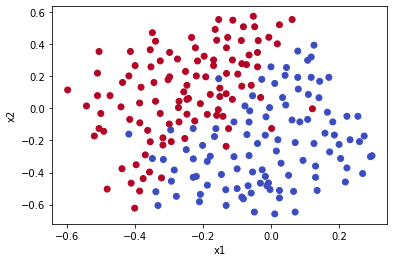

In [2]:
train_x, train_y, test_x, test_y = DataManagement.load_dataset_2D_points("data/data_points/data")

plt.scatter(train_x[0], train_x[1], c=train_y, cmap=plt.cm.coolwarm)
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

## Training a model
In this chapter, I will train four different models and then analyze thier performances. Models are going to be trained:
- without regularizarion
- with L2 regularization
- with dropout regularization
- with L2 and dropout regularization

Before the training, let's define some models parameters:

In [3]:
hidden_layer_dims = [20, 20, 5]
l_rate = 0.3
num_epochs = 30000

<strong>Note</strong>: all models will use the same default activation function ReLu.

Let's also create DataFrame that will store values of cost functions (I am using multi-indexing for the later use of <em>gradient_visualization</em> method).
Later on I will also create a DataFrame for metrics.

Moreover, in NeuralNetwork model there is a private method called initialize_params - it initializes parameters randomlny for every each layer. Due to this fact, I will use the same random seed before running a model, so every model will starts with the same initial parameters and repeatability of results is going to be maintained as well.

<strong>Last but not least</strong>, the decision boundary of a trained model is going to be plotted just after training, but I am going to store values of costs functions and metrics in dataframes. This is because it will be easier to compare models after every each one of them is trained.

In [4]:
indexes = [['regularization']*4, ['no regularization', 'l2', "dropout", "l2_dropout"]]
models_costs = pd.DataFrame(columns=['cost'], index=indexes)

### Model without regularization

In [5]:
method = "no regularization"
np.random.seed(3)
model = NeuralNetworkModel(hidden_layer_dims, learning_rate=l_rate, num_epochs=num_epochs, save_costs=1000,
                           mini_batch_size=0)
model.fit(train_x, train_y)
models_costs.loc[("regularization", str(method)), "cost"] = model.get_costs()

Cost after iteration 29999: 0.00013646418347285482


In [6]:
preds = model.predict(test_x)
proba = model.predict_proba(test_x)
model_metrics = basic_metrics(test_y, preds, proba)
metrics = pd.DataFrame(columns=model_metrics.keys())
metrics.loc[method] = model_metrics

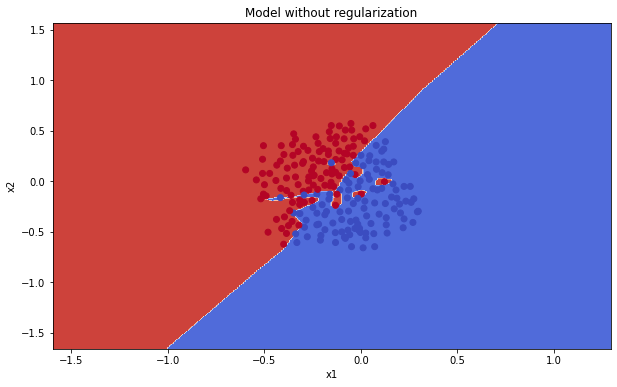

In [7]:
plt.figure(figsize=(10, 6))
plt.title("Model without regularization")
Visualization.plot_decision_boundary(lambda x: model.predict(x.T), train_x, train_y)

On the plot above, model overfits the data. It is noticeable that model without regularization tries to hard to classify every example from training set correctly. This model does not generalize well on the examples outside of a training set - it will also be shown in analysis of metrics at the end of this notebook

### Model with L2 regularization
L2-regularization relies on the assumption that a model with small weights is simpler than a model with large weights. Intercept is not penalized at all so it has greater impact on model - model will fit "simpler" function. By penalizing the square values of the weights in the cost function, all the weights are driven to smaller values. It becomes too costly for the cost to have large weights! This leads to a smoother model in which the output changes more slowly as the input changes.

In [8]:
method = "l2"
np.random.seed(3)
model_l2 = NeuralNetworkModel(hidden_layer_dims, learning_rate=l_rate, num_epochs=num_epochs, save_costs=1000 ,
                              l2_lambda=0.4, mini_batch_size=0)
model_l2.fit(train_x, train_y)
models_costs.loc[("regularization", str(method)), "cost"] = model_l2.get_costs()

Cost after iteration 29999: 0.2291880164731639


In [9]:
preds_l2 = model_l2.predict(test_x)
proba_l2 = model_l2.predict_proba(test_x)
metrics.loc[method] = basic_metrics(test_y, preds_l2, proba_l2, )

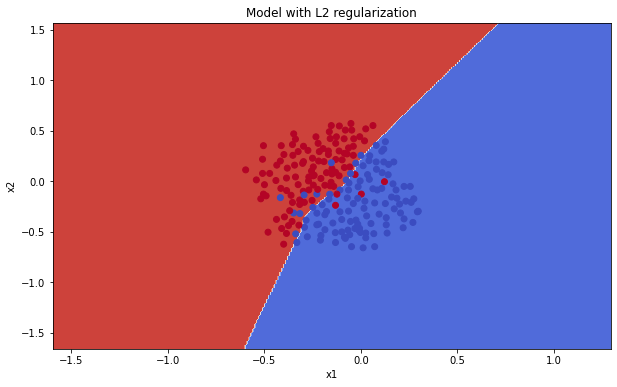

In [10]:
plt.figure(figsize=(10, 6))
plt.title("Model with L2 regularization")
Visualization.plot_decision_boundary(lambda x: model_l2.predict(x.T), train_x, train_y)

Model is not overfitted. It generalize well, outliner does not have such impact on predictions

### Model with dropout regularization
**Dropout randomly shuts down some neurons in each iteration.**

When you shut some neurons down, you actually modify your model. The idea behind drop-out is that at each iteration, you train a different model that uses only a subset of your neurons. With dropout, your neurons thus become less sensitive to the activation of one other specific neuron, because that other neuron might be shut down at any time. 

Subset of neurons that model uses is defined by **dropout_keep_prob** parameter. It ranges between 0-1, where 1 means - use all neurons, 0.7 means use randomly selected 70% neurons from previous layer etc.

**Implementation note**: during training time, divide each dropout layer by keep_prob to keep the same expected value for the activations. For example, if keep_prob is 0.5, then we will on average shut down half the nodes, so the output will be scaled by 0.5 since only the remaining half are contributing to the solution. Dividing by 0.5 is equivalent to multiplying by 2. Hence, the output now has the same expected value. You can check that this works even when keep_prob is other values than 0.5.

In [11]:
method = "dropout"
np.random.seed(3)
model_dropout = NeuralNetworkModel(hidden_layer_dims, learning_rate=l_rate, num_epochs=num_epochs,
                                   save_costs=1000, dropout_keep_prob=0.7, mini_batch_size=0)
model_dropout.fit(train_x, train_y)
models_costs.loc[("regularization", str(method)), "cost"] = model_dropout.get_costs()

Cost after iteration 29999: 0.2049220153966972


In [12]:
preds_dropout = model_dropout.predict(test_x)
proba_dropout = model_dropout.predict_proba(test_x)
metrics.loc[method] = basic_metrics(test_y, preds_dropout, proba_dropout)

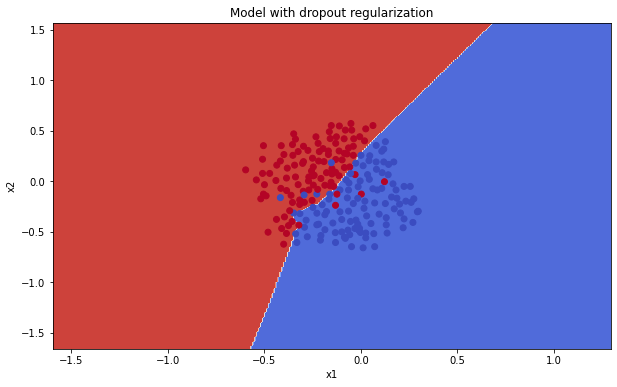

In [13]:
plt.figure(figsize=(10, 6))
plt.title("Model with dropout regularization")
Visualization.plot_decision_boundary(lambda x: model_dropout.predict(x.T), train_x, train_y)

### Model with L2 and dropout regularization
It is possible to mix regularization techniques. Let's give it a try.

In [14]:
method = "l2_dropout"
np.random.seed(3)
model_l2_dropout = NeuralNetworkModel(hidden_layer_dims, learning_rate=l_rate, num_epochs=num_epochs,
                                   save_costs=1000, l2_lambda=0.1, dropout_keep_prob=0.9, mini_batch_size=0)
model_l2_dropout.fit(train_x, train_y)
models_costs.loc[("regularization", str(method)), "cost"] = model_l2_dropout.get_costs()

Cost after iteration 29999: 0.15969438495075353


In [15]:
preds_l2_dropout = model_l2_dropout.predict(test_x)
proba_l2_dropout = model_l2_dropout.predict_proba(test_x)
metrics.loc[method] = basic_metrics(test_y, preds_l2_dropout, proba_l2_dropout)

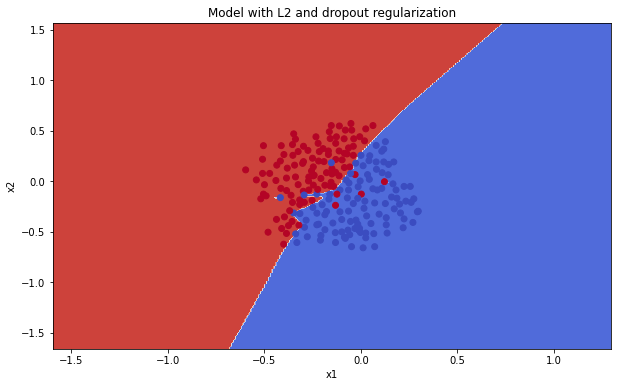

In [16]:
plt.figure(figsize=(10, 6))
plt.title("Model with L2 and dropout regularization")
Visualization.plot_decision_boundary(lambda x: model_l2_dropout.predict(x.T), train_x, train_y)

## Overall analysis and summary
As we seen before, model with no regularization overfits the data. It tries to hard to be perfectly fitted to training data, even if an specific example is an outlayer. Due to that fact, it generalize poory on new examples. To better understand this situation, let's see a gradient visualization of those models

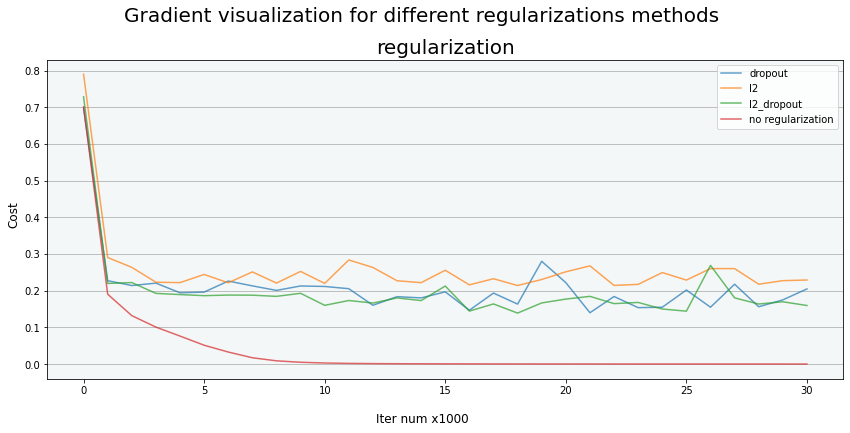

In [17]:
Visualization.gradient_visualization(models_costs.cost, 1000,
                                     "Gradient visualization for different regularizations methods")

Model with no regularization has low value of cost function - it mean that during training it manages to learn examples very well - the less value of cost function, the less mistakes during training. There is one ***but***, when it comes to new examples if will fail to generalize, because this model even learned outlayers. The metrics below confirm that the model with regularization techniques (and higher cost values) better predicts new examples. The key is to find a perfect balance, when models fits training and new data <em>"just right"</em>

In [18]:
metrics

,accuracy,f1,precision,recall,AUC
no regularization,0.915,0.899408,0.926829,0.873563,0.944411
l2,0.950,0.943182,0.932584,0.954023,0.963483
dropout,0.945,0.934911,0.963415,0.908046,0.953108
l2_dropout,0.945,0.935673,0.952381,0.919540,0.955752
